In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
import random
from astropy.stats import median_absolute_deviation
from scipy.signal import butter,filtfilt
from scipy.signal import butter, lfilter
import scipy.stats
import logging
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=1):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
label = {
    'L7cm_22mJ' : 0,
    'L7cm_35mJ' : 1,
    'L7cm_50mJ' : 2,
    'L7cm_65mJ' : 3,
    'L20cm_22mJ' : 4,
    'L20cm_35mJ' : 5,
    'L20cm_50mJ' : 6,
    'L20cm_65mJ' : 7
}
e_t = []
def prep_file(file):
    file_name = file.split('/')[-2]
    file_name = file_name.split('_')
    file_name = file_name[0]+'_' +file_name[1]

    x = np.array(pd.read_csv(file,header=None).iloc[15021:515021,1],dtype=np.float16)
    x2 = x- np.mean(x)

    x = butter_lowpass_filter(x, 200000, 100000000, 3)
    #x = butter_bandpass_filter(x, 1000, 200000, 100000000, 1)
    #x_fftp = x_fftp[:len(x_fftp)//2]
    #freq = freq[:len(freq)//2]
    x_fft_amp = np.fft.fft(x2)
    x_fft_amp = np.abs(x_fft_amp.real[:3000])
    freq = np.fft.fftfreq(n=x.size, d=1/100000000)
    freq = freq[:3000]
    
    start_time = time.time()
    x_t = np.r_[np.mean(x), np.std(x), np.var(x),
                np.max(x), np.min(x), (np.max(x) - np.min(x)),
                scipy.stats.skew(x), scipy.stats.kurtosis(x),
                np.sum(np.multiply(x, x))]
    
    x_t = np.r_[x_t, np.mean(x_fft_amp), np.std(x_fft_amp), np.var(x_fft_amp),
                median_absolute_deviation(x_fft_amp),
                np.amax(x_fft_amp), freq[np.argmax(x_fft_amp)],
                np.sum(np.multiply(x_fft_amp, x_fft_amp))]
    end_time = time.time()

    if np.isnan(x_t).any():
        return 0
    x_t = np.r_[x_t,np.array(label[file_name])]

    # Calculate the execution time in milliseconds
    feature_time_ms = (end_time - start_time) * 1000
    e_t.append(feature_time_ms)
    #print(f"Feature extraction time: {feature_time_ms} ms")
    return x_t.reshape(1, len(x_t))

In [4]:
dirtory = glob('./updated_dataset/old_underwater_dataset/*/*.csv')
random.shuffle(dirtory)

x = prep_file(dirtory[0])
for i in tqdm(range(1,2401)):
    try:
        x = np.r_[x,prep_file(dirtory[i])]
    except ValueError:
        print(dirtory[i]+'is not properly formated')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 46%|████▌     | 1109/2400 [05:31<06:02,  3.56it/s]

./updated_dataset/old_underwater_dataset/L20cm_22mJ_90d/tek0301CH1.csvis not properly formated


100%|██████████| 2400/2400 [12:01<00:00,  3.33it/s]


In [ ]:
print(f"Mean time for feature extraction: {np.mean(e_t)} ms")

In [ ]:
dirtory = glob('./updated_dataset/old_underwater_dataset/*/*.csv')

for i in tqdm(range(1,100)):
    try:
        x = prep_file(dirtory[i])
        
    except ValueError:
        print(dirtory[i]+'is not properly formated')
print(np.mean(e_t))

In [10]:
x_t = x[:,:-1]
y_t = x[:,-1]
print(x_t.shape)
print(y_t.shape)

(2400, 16)
(2400,)


In [11]:
# Feature normalization using min_max normalization
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x_t = mm.fit_transform(x_t)

In [ ]:
# x_t = np.delete(x_t,[3,13,14], 1)
# print(x_t.shape)

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

kf = KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
for train_index, test_index in kf.split(x_t):
    clf = make_pipeline(SVC(gamma='auto',kernel='sigmoid'),verbose =True) #‘linear’, ‘rbf’, ‘sigmoid’ ‘scale’, ‘auto’
    clf.fit(x_t[train_index], y_t[train_index])

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)
test_acc = np.array(test_acc)
train_acc = np.array(train_acc)

cm = np.zeros((8,8))

for j in range(5):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("SVM Train Accuracy = ",np.mean(train_acc),'%')
print("SVM Test Accuracy = ",np.mean(test_acc),'%')

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
for train_index, test_index in kf.split(x_t):
    clf = KNeighborsClassifier(n_neighbors=5) #weights='uniform'
    clf.fit(x_t[train_index], y_t[train_index])

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)
test_acc = np.array(test_acc)
train_acc = np.array(train_acc)

cm = np.zeros((8,8))

for j in range(5):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("KNN Train Accuracy = ",np.mean(train_acc),'%')
print("KNN Test Accuracy = ",np.mean(test_acc),'%')

# DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import tree
import graphviz

kf = KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(x_t2)
print(x_t2.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
test_precision = []
train_precision = []
test_recall = []
train_recall = []
train_f1 = []
test_f1 = []

for train_index, test_index in kf.split(x_t2):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=35) #gini, entropy
    clf.fit(x_t2[train_index], y_t[train_index])

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)
    
    test_precision.append(precision_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_precision.append(precision_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_recall.append(recall_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_recall.append(recall_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_f1.append(f1_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_f1.append(f1_score(y_t[train_index], y_pred2, average = 'macro')*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)
# test_acc = np.array(test_acc)
# train_acc = np.array(train_acc)
importances = clf.feature_importances_
print(importances)

cm = np.zeros((8,8))

for j in range(5):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("DT Train Accuracy = ",np.mean(train_acc),'%')
print("DT Test Accuracy = ",np.mean(test_acc),'%')

print('Precision Train: %.3f' % np.mean(train_precision),'%')
print('Precision Test: %.3f' % np.mean(test_precision),'%')


print('Recall Train: %.3f' % np.mean(train_recall),'%')
print('Recall Test: %.3f' % np.mean(test_recall),'%')

print('F1 Score Train: %.3f' % np.mean(train_f1),'%')
print('F1 Score Test: %.3f' % np.mean(test_f1),'%')

In [61]:
import time

E_T = []
print(x_t.shape)
# from time import time
for i in range(10):
    # Record the start time
    start_time = time.time()
    
    y_pred = clf.predict(x_t[i, 4:5].reshape((1, 1)))
    
    end_time = time.time()

    # Calculate the execution time in milliseconds
    execution_time_ms = (end_time - start_time) * 1000

    print(f"Execution time: {execution_time_ms} ms")
    
    E_T.append(execution_time_ms)
print(np.mean(E_T))
    

(2400, 13)
Execution time: 0.9777545928955078 ms
Execution time: 0.1575946807861328 ms
Execution time: 0.06461143493652344 ms
Execution time: 0.055789947509765625 ms
Execution time: 0.06747245788574219 ms
Execution time: 0.26917457580566406 ms
Execution time: 0.2732276916503906 ms
Execution time: 0.1220703125 ms
Execution time: 0.09322166442871094 ms
Execution time: 0.09846687316894531 ms
0.21793842315673828


# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
test_precision = []
train_precision = []
test_recall = []
train_recall = []
train_f1 = []
test_f1 = []

for train_index, test_index in kf.split(x_t):
    clf = RandomForestClassifier(n_estimators=100, criterion='entropy',max_depth=20, random_state=30) #gini, entropy,None
    start_time = time.time()
    clf.fit(x_t[train_index], y_t[train_index])
    end_time = time.time()
    
    Training_time_ms = (end_time - start_time) * 1000

    print(f"Training time: {Training_time_ms} ms")

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)
    
    test_precision.append(precision_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_precision.append(precision_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_recall.append(recall_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_recall.append(recall_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_f1.append(f1_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_f1.append(f1_score(y_t[train_index], y_pred2, average = 'macro')*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)
importances = clf.feature_importances_
print(importances)


cm = np.zeros((8,8))

for j in range(n):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("RF Train Accuracy = ",np.mean(train_acc),'%')
print("RF Test Accuracy = ",np.mean(test_acc),'%')

print('Precision Train: %.3f' % np.mean(train_precision),'%')
print('Precision Test: %.3f' % np.mean(test_precision),'%')

print('Recall Train: %.3f' % np.mean(train_recall),'%')
print('Recall Test: %.3f' % np.mean(test_recall),'%')

print('F1 Score Train: %.3f' % np.mean(train_f1),'%')
print('F1 Score Test: %.3f' % np.mean(test_f1),'%')

# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
for train_index, test_index in kf.split(x_t):
    #clf = LinearDiscriminantAnalysis(solver='svd') #‘svd’, ‘lsqr’, ‘eigen’
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(x_t[train_index], y_t[train_index])

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)

cm = np.zeros((8,8))

for j in range(n):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("LDA Train Accuracy = ",np.mean(train_acc),'%')
print("LDA Test Accuracy = ",np.mean(test_acc),'%')

# LR

In [ ]:
from sklearn.linear_model import LogisticRegression

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
for train_index, test_index in kf.split(x_t):
    clf = LogisticRegression(penalty='l2', solver='liblinear') #‘l1’,‘l2’,‘elasticnet’,‘none’,,,‘newton-cg’,‘lbfgs’,‘liblinear’, ‘sag’, ‘saga’
    clf.fit(x_t[train_index], y_t[train_index])

    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)

cm = np.zeros((8,8))

for j in range(n):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("LR Train Accuracy = ",np.mean(train_acc),'%')
print("LR Test Accuracy = ",np.mean(test_acc),'%')

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=False)
kf.get_n_splits(x_t)
print(x_t.shape)

cm1_list = []
cm2_list = []
test_acc = []
train_acc = []
test_precision = []
train_precision = []
test_recall = []
train_recall = []
train_f1 = []
test_f1 = []

for train_index, test_index in kf.split(x_t):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=20, random_state=0)
    #loss= 'log_loss' , 'deviance' , exponential
    clf.fit(x_t[train_index], y_t[train_index])
    y_pred = clf.predict(x_t[test_index])
    y_pred2 = clf.predict(x_t[train_index])
    
    cm1_list.append(confusion_matrix(y_t[test_index], y_pred))
    test_acc.append(metrics.accuracy_score(y_t[test_index], y_pred)*100)
    cm2_list.append(confusion_matrix(y_t[train_index], y_pred2))
    train_acc.append(metrics.accuracy_score(y_t[train_index], y_pred2)*100)
    
    test_precision.append(precision_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_precision.append(precision_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_recall.append(recall_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_recall.append(recall_score(y_t[train_index], y_pred2, average = 'macro')*100)
    
    test_f1.append(f1_score(y_t[test_index], y_pred, average = 'macro')*100)
    train_f1.append(f1_score(y_t[train_index], y_pred2, average = 'macro')*100)

cm1_list = np.array(cm1_list)
cm2_list = np.array(cm2_list)
importances = clf.feature_importances_
print(importances)


cm = np.zeros((8,8))

for j in range(n):
    cm = np.add(cm,cm1_list[j])
    
print(cm)
print("Gradient Boosting Train Accuracy = ",np.mean(train_acc),'%')
print("Gradient Boosting Test Accuracy = ",np.mean(test_acc),'%')

print('Precision Train: %.3f' % np.mean(train_precision),'%')
print('Precision Test: %.3f' % np.mean(test_precision),'%')


print('Recall Train: %.3f' % np.mean(train_recall),'%')
print('Recall Test: %.3f' % np.mean(test_recall),'%')

print('F1 Score Train: %.3f' % np.mean(train_f1),'%')
print('F1 Score Test: %.3f' % np.mean(test_f1),'%')

# Confusion Matrix

<AxesSubplot:title={'center':'UWN position = 90 degree'}, xlabel='Predicted labels', ylabel='Actual labels'>

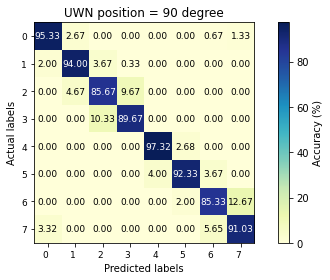

In [129]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True,title=None,cmap=plt.cm.YlGnBu):
    if not title:
        title = 'UWN position = 90 degree'

    #calculataion normalized confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm*100
    logging.info("Normalized confusion matrix")
    logging.info(cm)

    #setting up plots
    fig, ax = plt.subplots(figsize = (7,4))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax, label ='Accuracy (%)')
    #show all ticks
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes, title=title,
        ylabel='Actual labels', xlabel='Predicted labels')
    ax.tick_params(labelsize = 9)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
#             if cm[i,j] > 0.09:
            ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center", size= 9,
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(cm, np.arange(8))
# name = 'd90'
# plt.savefig(name + '.svg', dpi = 300,bbox_inches='tight')

# Execusion Time

In [111]:
import time

E_T = []
#y_pred = clf.predict(x_t[test_index])
print(x_t.shape)
# from time import time
for i in range(1000):
    # Record the start time
    start_time = time.time()
    y_pred = clf.predict(x_t[i].reshape((1, 16)))
    
    end_time = time.time()

    # Calculate the execution time in milliseconds
    execution_time_ms = (end_time - start_time) * 1000

    #print(f"Execution time: {execution_time_ms} ms")
    
    E_T.append(execution_time_ms)
print(np.mean(E_T))

(2400, 16)
0.03031635284423828
